Target: \
Improve the performance of the model by adding batchnormalization. Also look for some stability in training by adding dropout.

Results: \
Parameters: 9,426 \
Best Train Accuracy: 99.62 \
Best Test Accuracy: 99.37 (99.45 in 12th epoch)

Analysis: \
Final test accuracy is very close to target of 99.40. \
Overfitting as performance on test data is lower. \
Training is not stable as accuracy of 99.45 was reached in 12th epoch but afterwards accuracy dropped. Hence, further stability in training is still required.

# Import Libraries

In [ ]:
# load required libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

## Data Transformations


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                     ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1
batch_size = 64

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else \
                  dict(shuffle=True, batch_size=batch_size//2)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model

In [ ]:
# construct cnn class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 96, kernel_size = 5, padding = 2)  # apply 64 channel convolution with kernel size 5*5 on image
        self.conv2 = nn.Conv2d(96, 16, kernel_size = 1)  # apply 64 channel convolution with kernel size 1*1 on image
        self.conv3 = nn.Conv2d(16, 16, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image
        self.conv4 = nn.Conv2d(16, 8, kernel_size = 1)  # apply 64 channel convolution with kernel size 1*1 on image
        self.conv5 = nn.Conv2d(8, 16, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image
        self.conv6 = nn.Conv2d(16, 10, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image

        self.batch_norm1 = nn.BatchNorm2d(96)  # batch normalization after convolution layer 1
        self.batch_norm2 = nn.BatchNorm2d(16)  # batch normalization after convolution layer 2
        self.batch_norm3 = nn.BatchNorm2d(16)  # batch normalization after convolution layer 3
        self.batch_norm4 = nn.BatchNorm2d(8)  # batch normalization after convolution layer 4
        self.batch_norm5 = nn.BatchNorm2d(16)  # batch normalization after convolution layer 5

        self.dropout = nn.Dropout(0.05)

        self.gap = nn.AdaptiveAvgPool2d(1)


    def forward(self, img):
        x = F.relu(self.batch_norm1(self.conv1(img)))  # input = 1 * 28 * 28, output = 96 * 28 * 28, rf = 5*5
        x = F.relu(self.batch_norm2(self.conv2(x)))  # input = 96 * 28 * 28, output = 16 * 28 * 28, rf = 5*5
        x = F.max_pool2d(x, 2)  # input = 16 * 28 * 28, output = 16 * 14 * 14, rf = 6*6
        x = self.dropout(x)

        x = F.relu(self.batch_norm3(self.conv3(x)))  # input = 16 * 14 * 14, output = 16 * 12 * 12, rf = 10*10
        x = F.relu(self.batch_norm4(self.conv4(x)))  # input = 16 * 12 * 12, output = 8 * 12 * 12, rf = 10*10
        x = F.max_pool2d(x, 2)  # input = 8 * 12 * 12, output = 8 * 6 * 6, rf = 12*12
        x = self.dropout(x)
        
        x = F.relu(self.batch_norm5(self.conv5(x)))  # input = 8 * 6 * 6, output = 16 * 4 * 4, rf = 20*20
        x = self.conv6(x)  # input = 16 * 4 * 4, output = 10 * 2 * 2, rf = 28*28
        x = self.gap(x)  # input = 10 * 2 *2, output = 10 * 1 * 1, rf = 32*32
        x = x.view(-1, 10)  # flatten cnn embedding

        img_out = F.log_softmax(x, dim = 1)  # output layer to output probabilities for label

        return img_out

# Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 28, 28]           2,496
       BatchNorm2d-2           [-1, 96, 28, 28]             192
            Conv2d-3           [-1, 16, 28, 28]           1,552
       BatchNorm2d-4           [-1, 16, 28, 28]              32
           Dropout-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 16, 12, 12]           2,320
       BatchNorm2d-7           [-1, 16, 12, 12]              32
            Conv2d-8            [-1, 8, 12, 12]             136
       BatchNorm2d-9            [-1, 8, 12, 12]              16
          Dropout-10              [-1, 8, 6, 6]               0
           Conv2d-11             [-1, 16, 4, 4]           1,168
      BatchNorm2d-12             [-1, 16, 4, 4]              32

# Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, split="Test"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        split, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.06583476066589355 Batch_id=937 Accuracy=94.48: 100%|██████████| 938/938 [00:20<00:00, 46.13it/s]



Test set: Average loss: 0.0659, Accuracy: 9782/10000 (97.82%)

EPOCH: 1


Loss=0.03000473603606224 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:18<00:00, 50.65it/s]



Test set: Average loss: 0.0393, Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Loss=0.005860371980816126 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [00:16<00:00, 55.38it/s]



Test set: Average loss: 0.0318, Accuracy: 9907/10000 (99.07%)

EPOCH: 3


Loss=0.004802419804036617 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:17<00:00, 54.99it/s]



Test set: Average loss: 0.0267, Accuracy: 9919/10000 (99.19%)

EPOCH: 4


Loss=0.00919875968247652 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:16<00:00, 56.26it/s]



Test set: Average loss: 0.0243, Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.0447070337831974 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:17<00:00, 54.96it/s]



Test set: Average loss: 0.0279, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.03710073232650757 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:17<00:00, 52.86it/s]



Test set: Average loss: 0.0252, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.003360309172421694 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:17<00:00, 54.42it/s]



Test set: Average loss: 0.0293, Accuracy: 9905/10000 (99.05%)

EPOCH: 8


Loss=0.011403288692235947 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:17<00:00, 54.61it/s]



Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.021365936845541 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:17<00:00, 55.15it/s]



Test set: Average loss: 0.0244, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.011438267305493355 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:16<00:00, 57.03it/s]



Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.025535114109516144 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:16<00:00, 55.34it/s]



Test set: Average loss: 0.0189, Accuracy: 9945/10000 (99.45%)

EPOCH: 12


Loss=0.0008350724820047617 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:16<00:00, 55.29it/s]



Test set: Average loss: 0.0212, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.04395304620265961 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:16<00:00, 55.46it/s]



Test set: Average loss: 0.0196, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.0018471162766218185 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:17<00:00, 54.60it/s]



Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)



# Final Model Performance

In [ ]:
test(model, device, train_loader, split = "Train")


Train set: Average loss: 0.0125, Accuracy: 59775/60000 (99.62%)



In [ ]:
test(model, device, test_loader, split = "Test")


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)



# Performance Plots

Text(0.5, 1.0, 'Test Accuracy')

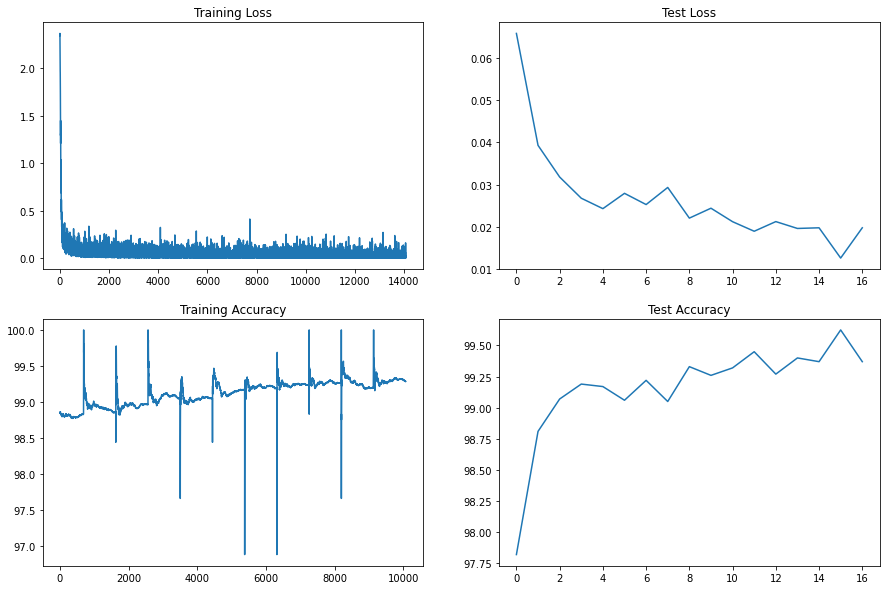

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")